# HW 1 Classification

Welcome to CS 6741 HW1. To begin this assignment first turn on the Python 3 and GPU backend for this Colab by clicking `Runtime > Change Runtime Type` above.  

In this homework you will be building several varieties of text classifiers. Text classifiers are not that exciting from an NLP point of view, but they are a great way to get up to speed on the core technologies we will use in this class.



## Goal

We ask that you construct the following models in PyTorch:

1. A naive Bayes unigram classifer (follow Wang and Manning http://www.aclweb.org/anthology/P/P12/P12-2.pdf#page=118: you should only implement Naive Bayes, not the combined classifer with SVM).
2. A logistic regression model over word types (you can implement this as $y = \sigma(\sum_i W x_i + b)$) 
3. A continuous bag-of-word neural network with embeddings (similar to CBOW in Mikolov et al https://arxiv.org/pdf/1301.3781.pdf ).
4. A simple convolutional neural network (any variant of CNN as described in Kim http://aclweb.org/anthology/D/D14/D14-1181.pdf ).
5. Your own extensions to these models...

Consult the papers provided for hyperparameters. 


## Setup

This notebook provides a working definition of the setup of the problem itself. You may construct your models inline or use an external setup (preferred) to build your system.

In [0]:
import torch
# Text text processing library and methods for pretrained word embeddings
import torchtext
from torchtext.vocab import Vectors, GloVe

The dataset we will use of this problem is known as the Stanford Sentiment Treebank ( https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf ). It is a variant of a standard sentiment classification task. For simplicity, we will use the most basic form. Classifying a sentence as positive or negative in sentiment. 

To start, `torchtext` requires that we define a mapping from the raw text data to featurized indices. These fields make it easy to map back and forth between readable data and math, which helps for debugging.

In [0]:
# Our input $x$
TEXT = torchtext.data.Field()

# Our labels $y$
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

Next we input our data. Here we will use the standard SST train split, and tell it the fields. Torchtext also gives us the option of using subtrees in the treebank as examples as well. The subtrees can be obtained by passing the option `train_subtrees=True` to splits. Feel free to experiment with using subtrees and report their effect on performance.

In [3]:
train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

trainDevTestTrees_PTB.zip:   0%|          | 0.00/790k [00:00<?, ?B/s]

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 3.27MB/s]


extracting


Let's look at this data. It's still in its original form, we can see that each example consists of a label and the original words.

Be sure to double check that examples with neutral labels were filtered out. 

The length of the training data should be 6920.

In [4]:
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))

len(train) 6920
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}


In order to map this data to features, we need to assign an index to each word an label. The function build vocab allows us to do this and provides useful options that we will need in future assignments.

In [5]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)
print('len(TEXT.vocab)', len(TEXT.vocab))
print('len(LABEL.vocab)', len(LABEL.vocab))

len(TEXT.vocab) 16284
len(LABEL.vocab) 2


Finally we are ready to create batches of our training data that can be used for training and validating the model. This function produces 3 iterators that will let us go through the train, val and test data. 

In [0]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test), batch_size=10, device=torch.device("cuda"))

Let's look at a single batch from one of these iterators. The library automatically converts the underlying words into indices. It then produces tensors for batches of x and y. In this case it will consist of the number of words of the longest sentence (with padding) followed by the number of batches. We can use the vocabulary dictionary to convert back from these indices to words.

In [7]:
batch = next(iter(train_iter))
print("Size of text batch:", batch.text.shape)
# example = batch.text.get("batch", 1)
example = batch.text[:,1]
print("Second in batch", example)
print("Converted back to string:", " ".join([TEXT.vocab.itos[i] for i in example.tolist()]))

Size of text batch: torch.Size([37, 10])
Second in batch tensor([  76, 2267,    5,  167, 2261,  135,   39, 4280,  129,    5,  128, 2673,
          68,  662,  484, 1446,   49, 3302,    2,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1], device='cuda:0')
Converted back to string: An ingenious and often harrowing look at damaged people and how families can offer either despair or consolation . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Similarly it produces a vector for each of the labels in the batch. 

In [8]:
print("Size of label batch:", batch.label.shape)
# example = batch.label.get("batch", 1)
example = batch.label[1]
print("Second in batch", example.item())
print("Converted back to string:", LABEL.vocab.itos[example.item()])

Size of label batch: torch.Size([10])
Second in batch 0
Converted back to string: positive


Finally the Vocab object can be used to map pretrained word vectors to the indices in the vocabulary. This will be very useful for part 3 and 4 of the problem.  Feel free to experiment with different word vectors and report their effect on performance.

In [9]:
# Build the vocabulary with word embeddings
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

print("Word embeddings size ", TEXT.vocab.vectors.size())
print("Word embedding of 'follows', first 10 dim ", TEXT.vocab.vectors[TEXT.vocab.stoi['follows']][:10])

.vector_cache/wiki.simple.vec: 293MB [00:04, 62.4MB/s]                           
100%|█████████▉| 110528/111051 [00:10<00:00, 10983.21it/s]

Word embeddings size  torch.Size([16284, 300])
Word embedding of 'follows', first 10 dim  tensor([ 0.3925, -0.4770,  0.1754, -0.0845,  0.1396,  0.3722, -0.0878, -0.2398,
         0.0367,  0.2800])


## Assignment

Now it is your turn to build the models described at the top of the assignment. 

Using the data given by this iterator, you should construct 4 different torch models that take in batch.text and produce a distribution over labels. 


In [0]:
def test_code(model):
    "All models should be able to be run with following command."
    upload = []
    # Update: for kaggle the bucket iterator needs to have batch_size 10
    test_iter = torchtext.data.BucketIterator(test, train=False, batch_size=10)
    for batch in test_iter:
        # Your prediction data here (don't cheat!)
        probs = model(batch.text)
        # here we assume that the name for dimension classes is `classes`
        _, argmax = probs.max('classes')
        upload += argmax.tolist()

    with open("predictions.txt", "w") as f:
        f.write("Id,Category\n")
        for i, u in enumerate(upload):
            f.write(str(i) + "," + str(u) + "\n")


#1. Naive Bayes unigram classifer 
Follows [Wang and Manning](https://www.aclweb.org/anthology/P12-2018.pdf).

In [0]:
"""
NaiveBayes
Author: Emily Tseng (et397)

--

"""

from tqdm import tqdm
import torch
import numpy as np


class NaiveBayes:
    def __init__(self, alpha, TEXT, LABEL):
        """
            Initializes with a given smoothing parameter
        """
        self.alpha = alpha
        self.vocab = TEXT.vocab
        self.labels = LABEL.vocab
        # Store which label is which
        self.label_map = {
            self.labels.itos[0]: 0,
            self.labels.itos[1]: 1
        }
        # Initialize with zero seen pos or neg samples
        self.p = self.alpha + np.zeros((len(self.vocab),))
        self.q = self.alpha + np.zeros((len(self.vocab),))
        # Initialize counts at 1 here also to prevent div by 0 error
        self.nplus = 1
        self.nminus = 1
        self.update()
    
    def update(self):
        self.r = np.log((self.p/np.linalg.norm(self.p, ord=1)) / (self.q/np.linalg.norm(self.q, ord=1)))
        self.b = np.log(self.nplus / self.nminus)

    def featurize(self, x):
        """
            Input: <vec> x
            Output: <vec> fx, featurized using the vocabulary
        """
        output = np.zeros((len(self.vocab),))
        for word_idx in x:
            output[word_idx] = 1
        return output

    def train(self, train_iter, val_iter):
        """
            "Trains" the model based on the provided train and val sets.
        """
        for batch_idx, train_batch in enumerate(train_iter):
            # Update the count vectors...
            for i in range(len(train_batch)):
                x = train_batch.text[:, i]
                fx = self.featurize(x)
                y = train_batch.label[i]
                if self.labels.itos[y.item()] == 'positive':
                  self.p += fx
                  self.nplus += 1
                else:
                  self.q += fx
                  self.nminus += 1
            # And recalculate r & b
            self.update()
            # Let's hope to see improvement at every 10 batches
            if batch_idx % 50 == 0:
              batch_acc = self.evaluate(val_iter)
              print('val acc after training batch {}: {}'.format(batch_idx, batch_acc))
              # print('\tself.p: {}\n\tself.q: {}\n\tself.r: {}\n\tself.b: {}'.format(self.p, self.q, self.r, self.b))


    def evaluate(self, val_iter):
        """
            Evaluates against a batch of given data.
        """
        correct = 0
        total = 0

        for batch_idx, val_batch in enumerate(val_iter):
            for i in range(len(val_batch)):
                x = val_batch.text[:, i]
                y = val_batch.label[i]
                fx = self.featurize(x)
                yhat = self.predict(fx)
                if y == yhat:
                    correct += 1
                total += 1
        
        return float(correct / total)

    def predict(self, x):
        val = np.matmul(self.r.T, x) + self.b
        if val >= 0:
            return self.label_map['positive']
        else:
            return self.label_map['negative']

In [12]:
alpha = 1
model = NaiveBayes(alpha, TEXT, LABEL)
model.train(train_iter, val_iter)
# Evaluate on training set first
train_acc = model.evaluate(train_iter)
print('NaiveBayes train_acc: ', train_acc)

Initialized NaiveBayes model with vocab size 16284, label size 2
	self.p: [1. 1. 1. ... 1. 1. 1.]
	self.q: [1. 1. 1. ... 1. 1. 1.]
	self.r: [0. 0. 0. ... 0. 0. 0.]
	self.b: 0.0
val acc after training batch 0: 0.5114678899082569
val acc after training batch 50: 0.5825688073394495
val acc after training batch 100: 0.6754587155963303
val acc after training batch 150: 0.7224770642201835
val acc after training batch 200: 0.7431192660550459
val acc after training batch 250: 0.7603211009174312
val acc after training batch 300: 0.7763761467889908
val acc after training batch 350: 0.768348623853211
val acc after training batch 400: 0.7786697247706422
val acc after training batch 450: 0.7844036697247706
val acc after training batch 500: 0.7878440366972477
val acc after training batch 550: 0.786697247706422
val acc after training batch 600: 0.7924311926605505
val acc after training batch 650: 0.7970183486238532
NaiveBayes train_acc:  0.9486994219653179


In [13]:
# Then run the test set
test_acc = model.evaluate(test_iter)
print('NaiveBayes test_acc: ', test_acc)

NaiveBayes test_acc:  0.8215266337177375


# 2) Logistic Regression

A logistic regression model over word types (you can implement this as $y = \sigma(\sum_i W x_i + b)$) 


In [0]:
"""
LogisticRegression
Author: Emily Tseng et397

--

"""

import torch
import torch.nn as nn
from torch.autograd import Variable

from tqdm import tqdm

class LogisticRegression(nn.Module):
  def __init__(self, input_size, output_size, batch_size):
    super(LogisticRegression, self).__init__()
    self.batch_size = batch_size
    self.vocab_size = input_size
    self.linear = torch.nn.Linear(input_size, output_size, bias=True)
  
  def forward(self, x):
    x.to(device)
    output = self.linear(x)
    output = torch.sigmoid(output)
    return output
  
  def featurize(self, x):
    """
      Input: <vec> x
      Output: <vec> fx, featurized using the vocabulary
    """
    output = np.zeros((self.vocab_size,))
    for word_idx in x:
        output[word_idx] = 1
    return output
  
  def featurize_batch(self, batch, train=True):
    """
      Takes in a batch from the training data and featurizes it as binarized counts.
    """
    output = np.zeros((self.batch_size, self.vocab_size)) #e.g. 10 x 6000
    for i in range(len(batch)):
      x = batch.text[:,i]
      fx = self.featurize(x)
      output[i] = fx
    if train:
      return Variable(torch.FloatTensor(output)).cuda(), batch.label
    else:
      return Variable(torch.FloatTensor(output)).cuda()
  
  def train_model(self, train_iter, val_iter, epochs, lr):
    """ Trains the model over the given parameters. Returns vector of epoch losses for plotting.
    """
    self.train()
    # Use SGD and CrossEnt
    crossent = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
      epoch_loss = 0.
      for batch_idx, batch in enumerate(train_iter):
        optimizer.zero_grad()
        batch_fx, batch_y = self.featurize_batch(batch, True)
        output = self.forward(batch_fx)
        loss = crossent(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      epoch_loss /= len(train_iter)
      losses.append(epoch_loss)
      val_acc = self.evaluate(val_iter)
      print('val acc after training epoch {}: {}'.format(epoch, val_acc))
      print('epoch loss: {}'.format(epoch_loss))
    return losses
  
  def evaluate(self, val_iter):
    """ Evaluates against a batch of given data.
    """
    self.eval()
    with torch.no_grad():
      correct = 0
      total = 0

      for batch_idx, batch in enumerate(val_iter):
        for i in range(len(batch)):
          x = batch.text[:, i]
          y = batch.label[i]
          fx = Variable(torch.FloatTensor(self.featurize(x))).cuda()
          output = self.forward(fx)
          yhat = output.max(0)[1]
          if y == yhat:
            correct += 1
          total += 1
      return float(correct / total)


In [29]:
lr = 5e-2
epochs = 20
batch_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logreg = LogisticRegression(len(TEXT.vocab), len(LABEL.vocab), batch_size)
logreg.to(device)

logreg_losses = logreg.train_model(train_iter, val_iter, epochs, lr)
test_acc = logreg.evaluate(test_iter)
print('final test_acc for LogReg: {}'.format(test_acc))

val acc after training epoch 0: 0.5458715596330275
epoch loss: 0.685959963440206
val acc after training epoch 1: 0.6422018348623854
epoch loss: 0.6742552167418375
val acc after training epoch 2: 0.6536697247706422
epoch loss: 0.6646205173062452
val acc after training epoch 3: 0.6605504587155964
epoch loss: 0.6573416831865476
val acc after training epoch 4: 0.6880733944954128
epoch loss: 0.6509218731884322
val acc after training epoch 5: 0.6880733944954128
epoch loss: 0.645462427525162
val acc after training epoch 6: 0.6754587155963303
epoch loss: 0.6405531319579637
val acc after training epoch 7: 0.6880733944954128
epoch loss: 0.6361205812134495
val acc after training epoch 8: 0.7018348623853211
epoch loss: 0.6319561226002742
val acc after training epoch 9: 0.6972477064220184
epoch loss: 0.6279672666781211
val acc after training epoch 10: 0.7110091743119266
epoch loss: 0.6244509506949111
val acc after training epoch 11: 0.7144495412844036
epoch loss: 0.6210844695051282
val acc after tr

# 3) CBOW

A continuous bag-of-word neural network with embeddings (similar to CBOW in Mikolov et al https://arxiv.org/pdf/1301.3781.pdf ).

In [0]:
"""
CBOW NN
Author: Emily Tseng et397

--



"""

import torch
import torch.nn as nn
from torch.autograd import Variable

from tqdm import tqdm

class CBOW(nn.Module):
  def __init__(self, embeddings, output_size, batch_size, pad_idx):
    super(CBOW, self).__init__()
    self.embeddings = nn.Embedding(embeddings.size(0), embeddings.size(1), padding_idx=pad_idx)
    self.linear = torch.nn.Linear(embeddings.size(1), output_size, bias=True)
  
  def forward(self, x):
    x.to(device)
    embedded_x = self.embeddings(x)
    # CBOW uses a vector of averaged word embeddings
    avg_embed = embedded_x.mean(0)
    output = self.linear(avg_embed)
    return nn.functional.log_softmax(output, dim=1)
  
  def predict(self, x):
    logits = self.forward(x)
    return logits.max(1)[1]
  
  def train_model(self, train_iter, val_iter, epochs, lr):
    """ Trains the model over the given parameters. Returns vector of epoch losses for plotting.
    """
    self.train()
    # Use SGD and CrossEnt
    crossent = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
      epoch_loss = 0.
      for batch_idx, batch in enumerate(train_iter):
        optimizer.zero_grad()
        yhat = self.forward(batch.text)
        loss = crossent(yhat, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      epoch_loss /= len(train_iter)
      losses.append(epoch_loss)
      print('epoch loss: {}'.format(epoch_loss))
      val_acc = self.evaluate(val_iter)
      print('val acc after training epoch {}: {}'.format(epoch, val_acc))
    return losses
  
  def evaluate(self, val_iter):
    """ Evaluates against a batch of given data.
    """
    with torch.no_grad():
      self.eval()
      correct = 0
      total = 0

      for batch_idx, batch in enumerate(val_iter):
        yhats = self.predict(batch.text)
        for i, yhat in enumerate(yhats):
          if batch.label[i] == yhat:
            correct += 1
          total += 1
      return float(correct / total)


In [33]:
lr = 5e-2
epochs = 20
batch_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pad_idx=TEXT.vocab.stoi[TEXT.pad_token]

cbow = CBOW(TEXT.vocab.vectors, len(LABEL.vocab), batch_size, pad_idx)
cbow.to(device)

cbow_losses = cbow.train_model(train_iter, val_iter, epochs, lr)
test_acc = cbow.evaluate(test_iter)
print('\nfinal test_acc for CBOW: {}'.format(test_acc))

epoch loss: 0.6739854291512098
val acc after training epoch 0: 0.6387614678899083
epoch loss: 0.6492111387452638
val acc after training epoch 1: 0.6422018348623854
epoch loss: 0.6345409881431243
val acc after training epoch 2: 0.6571100917431193
epoch loss: 0.6255833912274741
val acc after training epoch 3: 0.6479357798165137
epoch loss: 0.619871094521415
val acc after training epoch 4: 0.6307339449541285
epoch loss: 0.6148916824015579
val acc after training epoch 5: 0.6387614678899083
epoch loss: 0.6103021444354443
val acc after training epoch 6: 0.6467889908256881
epoch loss: 0.6080563691999182
val acc after training epoch 7: 0.6387614678899083
epoch loss: 0.6038626094343346
val acc after training epoch 8: 0.6456422018348624
epoch loss: 0.6011746638599847
val acc after training epoch 9: 0.6536697247706422
epoch loss: 0.5984734961321588
val acc after training epoch 10: 0.6456422018348624
epoch loss: 0.5953932171525983
val acc after training epoch 11: 0.6548165137614679
epoch loss: 0.5

# 4) CNN

A simple convolutional neural network (any variant of CNN as described in Kim http://aclweb.org/anthology/D/D14/D14-1181.pdf ).

In [0]:
import numpy as np

def sanitize_batch(batch, min_length):
  """
    If a batch contains sentences less than a defined minimum length, pad it.
  """
  if batch.text.size(0) < min_length:
    nparr = batch.text.data.cpu().numpy()
    nparr = nparr.T
    output = np.zeros((nparr.shape[0], min_length))
    for i, sentence in enumerate(nparr):
      output[i] = np.concatenate((sentence, [pad_idx] * (min_length - nparr.shape[1])))
    return torch.LongTensor(output.T).to(device)
  else:
    return batch.text


In [0]:
"""
CNN
Author: Emily Tseng et397

--

"""

import torch
import torch.nn as nn
from torch.autograd import Variable

from tqdm import tqdm

class CNN(nn.Module):
  def __init__(self, embeddings, output_size, pad_idx, init_embed=False):
    super(CNN, self).__init__()
    vocab_size = embeddings.size(0)
    embed_dim = embeddings.size(1)
    self.pad_idx = pad_idx

    # Shared embedding layer, |V| x embed_dim 
    self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
    if init_embed:
      self.embeddings.weight.data.copy_(embeddings)

    # Convolutional layers. Per Kim:
    #   window sizes h=3,4,5 
    #   "100 feature maps" = output size is 100
    self.convs = nn.ModuleList([
                                nn.Conv2d(1, 100, kernel_size=(window_size, embed_dim))
                                for window_size in [3,4,5]
    ])

    # Dropout layer with p=0.5 per Kim
    self.dropout = nn.Dropout(p=0.5)

    # And includes 1 linear layer. 3 filters of size=100 each -> 300
    self.linear = torch.nn.Linear(300, output_size, bias=True)
  
  def forward(self, x, train):
    # x: (max sentence length, batch size)
    x = x.T
    # x: (batch size, max sentence length)
    x.to(device)

    embedded_x = self.embeddings(x).unsqueeze(1)
    # embedded_x: (batch size, 1, max sentence length, embed_dim)

    # Push the sentence through each of the 3 convs + activate via ReLU per Kim
    conved_x = [nn.functional.relu(conv(embedded_x).squeeze(3)) for conv in self.convs]
    # conv_3: (batch size, 100, max sentence length - 3 + 1) etc

    # Apply max-pooling over each of the layers
    pooled_x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conved_x]
    # pooled_3: (batch size, 100) etc

    # Then concat.
    # output: (batch size, 100 * 3)
    output = torch.cat(pooled_x, dim=1)

    # If training, apply dropout at the penultimate layer for regularization per Kim
    if train:
      output = self.dropout(output)

    # Then apply ultimate linear + softmax
    output = self.linear(output)
    return nn.functional.log_softmax(output, dim=1)
  
  def predict(self, x):
    logits = self.forward(x, train=False)
    return logits.max(1)[1]
  
  def train_model(self, train_iter, val_iter, epochs, lr):
    """ Trains the model over the given parameters. Returns vector of epoch losses for plotting.
    """
    self.train()
    # Use Adadelta (per Kim) and CrossEnt
    lossfunc = torch.nn.CrossEntropyLoss()
    lossfunc.to(device)
    optimizer = torch.optim.Adadelta(self.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
      epoch_loss = 0.
      for batch_idx, batch in enumerate(train_iter):
        optimizer.zero_grad()
        # Sanitize so it's at least 5 long
        sanitized_batch = sanitize_batch(batch, 5)
        yhat = self.forward(sanitized_batch, train=True)
        loss = lossfunc(yhat, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      epoch_loss /= len(train_iter)
      losses.append(epoch_loss)
      print('epoch loss: {}'.format(epoch_loss))
      val_acc = self.evaluate(val_iter)
      print('val acc after training epoch {}: {}'.format(epoch, val_acc))
    return losses
  
  def evaluate(self, val_iter):
    """ Evaluates against a batch of given data.
    """
    with torch.no_grad():
      self.eval()
      correct = 0
      total = 0
      for batch_idx, batch in enumerate(val_iter):
        sanitized_batch = sanitize_batch(batch, 5)
        yhats = self.predict(sanitized_batch)
        for i, yhat in enumerate(yhats):
          if batch.label[i] == yhat:
            correct += 1
          total += 1
      return float(correct / total)


In [22]:
lr = 5e-2
epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pad_idx=TEXT.vocab.stoi[TEXT.pad_token]

cnn = CNN(TEXT.vocab.vectors, len(LABEL.vocab), pad_idx, init_embed=False)
cnn.to(device)

cnn_losses = cnn.train_model(train_iter, val_iter, epochs, lr)
test_acc = cnn.evaluate(test_iter)
print('\nfinal test_acc for CNN: {}'.format(test_acc))

epoch loss: 0.7379388183010795
val acc after training epoch 0: 0.6823394495412844
epoch loss: 0.5404441770532228
val acc after training epoch 1: 0.7029816513761468
epoch loss: 0.37976736844533443
val acc after training epoch 2: 0.7144495412844036
epoch loss: 0.23034781023773843
val acc after training epoch 3: 0.6972477064220184
epoch loss: 0.11523454824753235
val acc after training epoch 4: 0.7087155963302753
epoch loss: 0.04644142206343741
val acc after training epoch 5: 0.7052752293577982
epoch loss: 0.015787602655288113
val acc after training epoch 6: 0.7110091743119266
epoch loss: 0.005460934482334516
val acc after training epoch 7: 0.7064220183486238
epoch loss: 0.002522401143329062
val acc after training epoch 8: 0.713302752293578
epoch loss: 0.0015340543166509522
val acc after training epoch 9: 0.7087155963302753
epoch loss: 0.0010889839801386891
val acc after training epoch 10: 0.7098623853211009
epoch loss: 0.0008271247297145205
val acc after training epoch 11: 0.7133027522935

In [37]:
lr = 5e-2
epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pad_idx=TEXT.vocab.stoi[TEXT.pad_token]

cnn2 = CNN(TEXT.vocab.vectors, len(LABEL.vocab), pad_idx, init_embed=True)
cnn2.to(device)

cnn2_losses = cnn2.train_model(train_iter, val_iter, epochs, lr)
test_acc = cnn2.evaluate(test_iter)
print('\nfinal test_acc for CNN: {}'.format(test_acc))

epoch loss: 0.6701995651156916
val acc after training epoch 0: 0.7052752293577982
epoch loss: 0.5995232576149048
val acc after training epoch 1: 0.7224770642201835
epoch loss: 0.521253361436673
val acc after training epoch 2: 0.7408256880733946
epoch loss: 0.4516537863265917
val acc after training epoch 3: 0.7511467889908257
epoch loss: 0.39364450506736776
val acc after training epoch 4: 0.7557339449541285
epoch loss: 0.3405065650195745
val acc after training epoch 5: 0.7557339449541285
epoch loss: 0.2907878750493761
val acc after training epoch 6: 0.7568807339449541
epoch loss: 0.24489140262385842
val acc after training epoch 7: 0.7385321100917431
epoch loss: 0.20239908056538228
val acc after training epoch 8: 0.7614678899082569
epoch loss: 0.1644754003830297
val acc after training epoch 9: 0.7694954128440367
epoch loss: 0.13099715119561536
val acc after training epoch 10: 0.7419724770642202
epoch loss: 0.10258676475613793
val acc after training epoch 11: 0.7786697247706422
epoch loss

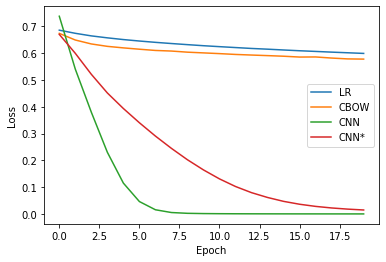

In [38]:
import matplotlib.pyplot as plt

def plot_losses(labeled_losses):
  """
    Input: [(losses, label), (losses2, label2)...]
    Plots them
  """
  for (losses, label) in labeled_losses:
    plt.plot(range(len(losses)), losses, label=label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

plot_losses([
             (logreg_losses, "LR"),
             (cbow_losses, "CBOW"),
             (cnn_losses, "CNN"),
             (cnn2_losses, "CNN*"),
])

In addition, you should put up a (short) write-up following the [template](https://github.com/harvardnlp/cs6741/tree/master/nlp-template) provided in the repository. 